In [216]:
ENV["PYTHONPATH"] = "/home/gridsan/aligho/.local/lib/python3.8/site-packages/PyNormaliz-2.15-py3.8-linux-x86_64.egg";
D = 2;
using HDF5, PyPlot
using DelimitedFiles, PyPlot, LinearAlgebra, JLD2, PyCall, StaticArrays, Statistics
using Crystalline, Brillouin, MPBUtils, SymmetryBases
using Crystalline: TEST_αβγs, TEST_αβγ, dot, norm
using Crystalline: normscale, matching_littlegroups
using Crystalline: AbstractFourierLattice
topology_paper_dir = "../../TopologyPaper/"
include(topology_paper_dir * "get-freqs-symeigs.jl")
include(topology_paper_dir * "symeigs-from-io.jl");
include("../../Topology_ML/Phc_ML/fft.jl")
include("../get_uc_coefs.jl");
np = pyimport("numpy");
using Random # Required for randperm

In [325]:
ns = [[0, 1, 0, 1, 0, 1, 1, 0, 1], [0, 1, 1, 0, 0, 1, 1, 0, 1], 
[0, 1, 0, 1, 1, 0, 1, 0, 1], [0, 1, 1, 0, 1, 0, 1, 0, 1], [1, 0, 0, 1, 0, 1, 1, 0, 1], 
[1, 0, 1, 0, 0, 1, 1, 0, 1], [1, 0, 0, 1, 1, 0, 1, 0, 1], [1, 0, 1, 0, 1, 0, 1, 0, 1]];
dir = "./inverse_design_smooth_symbols_random/output/sg2/tm/";
root_dir_two_tone = "./inverse_design_two_tone_symbols_random/"
contrast_dir = root_dir_two_tone * "changing_contrast/output/sg2/tm/contrast6/"; # Highest contrast

In [326]:
filename = "sg2-tm.jld2";
loaded_data = load(dir * filename);
N = 250
symmetries_smooth = [[x[1].n for x in loaded_data["summariesv"][1+topological_class*N:(topological_class+1)*N]] for topological_class in range(0, 7)];

In [327]:
dir = "inverse_design_two_tone_symbols_random/";
expect_to_be_good = []
for n in range(0, 7)
    filename = "two_tone_scores-class$(n).h5"
    f = h5open(dir * filename, "r")
    which_good = findall(x-> x == n, np.argmax(f["two_tone_classifications"][], axis=0))
    push!(expect_to_be_good, which_good)
end

In [328]:
dir = "./inverse_design_two_tone_symbols_random/output/sg2/tm/";
filename = "sg2-tm.jld2";
loaded_data = load(dir * filename);
N = 250
symmetries_two_tone = [[x[1].n for x in loaded_data["summariesv"][1+topological_class*N:(topological_class+1)*N]] for topological_class in range(0, 7)];

In [329]:
loaded_data_v = []
for contrast_idx in 1:6
    contrast_dir = "./inverse_design_two_tone_symbols_random/changing_contrast/output/sg2/tm/contrast$(contrast_idx)/"
    filename = "sg2-tm-contrast$(contrast_idx).jld2";
    loaded_data = load(contrast_dir * filename);
    push!(loaded_data_v, loaded_data)
end
N = 250
symmetries_v = [[[x[1].n for x in loaded_data_v[contrast_idx]["summariesv"][1+topological_class*N:(topological_class+1)*N]] for topological_class in range(0, 7)] for contrast_idx in range(1, 6)];

In [330]:
filtered_filtered_indices_v = Vector{Int64}[]
for (topological_class, filtered_indices) in enumerate(expect_to_be_good)
    num_filtered_indices = length(filtered_indices)
    random_filtered_indices = filtered_indices[randperm(num_filtered_indices)[1:10]]
    filtered_filtered_indices = []
    for filtered_index in random_filtered_indices 
        symmetries_smooth[topological_class][filtered_index] == ns[topological_class] || continue
        symmetries_two_tone[topological_class][filtered_index] == ns[topological_class] || continue
        symmetries_v[1][topological_class][filtered_index] == ns[topological_class] || continue
        symmetries_v[2][topological_class][filtered_index] == ns[topological_class] || continue
        symmetries_v[3][topological_class][filtered_index] == ns[topological_class] || continue
        symmetries_v[4][topological_class][filtered_index] == ns[topological_class] || continue
        symmetries_v[5][topological_class][filtered_index] == ns[topological_class] || continue
        symmetries_v[6][topological_class][filtered_index] == ns[topological_class] || continue
        push!(filtered_filtered_indices, filtered_index)
    end
    push!(filtered_filtered_indices_v, filtered_filtered_indices)
end

In [331]:
for (topological_class, filtered_filtered_indices) in enumerate(filtered_filtered_indices_v)
    println("Topological class: ", topological_class)
    @assert all(x -> x in expect_to_be_good[topological_class], filtered_filtered_indices) 
    @assert all(x -> symmetries_smooth[topological_class][x] == ns[topological_class], filtered_filtered_indices)
    @assert all(x -> symmetries_two_tone[topological_class][x] == ns[topological_class], filtered_filtered_indices)
    for contrast_idx in 1:6
        @assert all(x -> symmetries_v[contrast_idx][topological_class][x] == ns[topological_class], filtered_filtered_indices)
    end
end

Topological class: 1
Topological class: 2
Topological class: 3
Topological class: 4
Topological class: 5
Topological class: 6
Topological class: 7
Topological class: 8


In [229]:
epsilons_v_v = Vector{Matrix{Float64}}[]
for (topological_class, filtered_filtered_indices) in enumerate(filtered_filtered_indices_v)
    epsilons_v = Matrix{Float64}[]
    for filtered_index in filtered_filtered_indices
        real_index = 100000 + (topological_class-1)*250 + filtered_index
        filename = contrast_dir * "dim2-sg2-$(real_index)-res64-tm-epsilon.h5"
        f = h5open(filename)
        epsilon = f["data"][];
        close(f);
        push!(epsilons_v, epsilon)
    end
    push!(epsilons_v_v, epsilons_v)
end

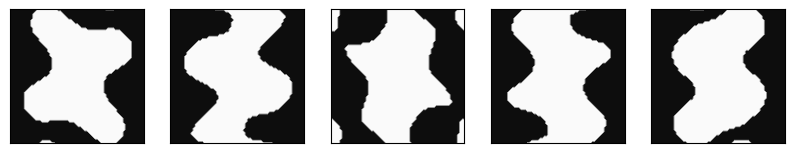

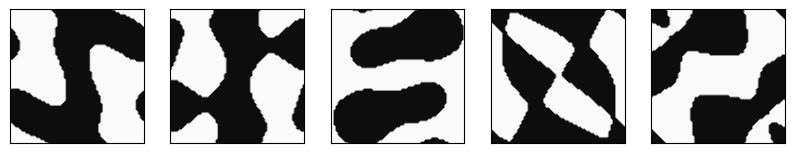

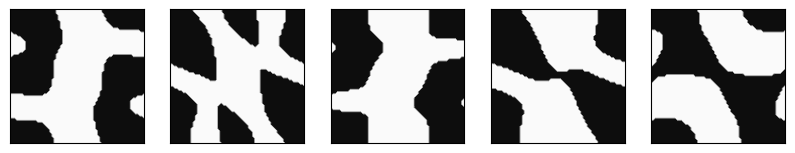

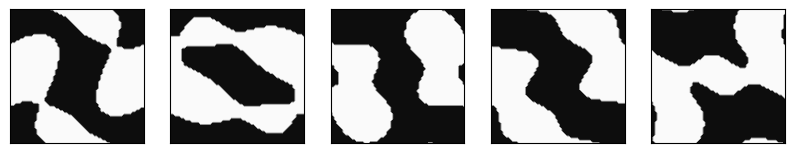

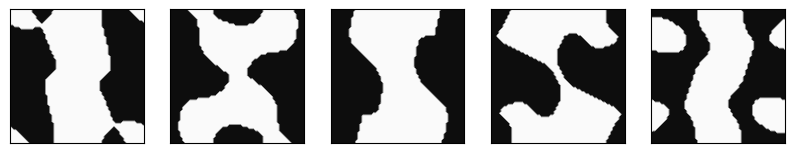

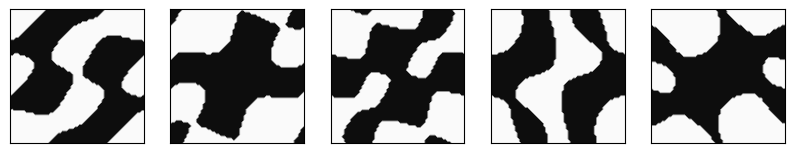

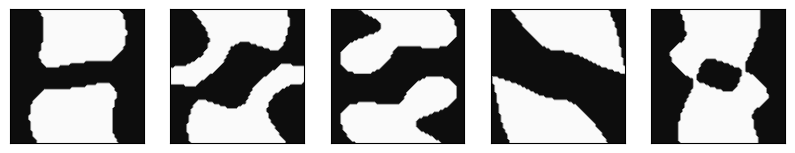

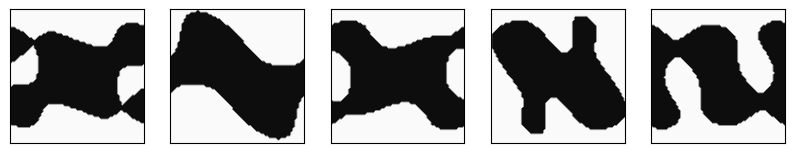

In [232]:
for topological_index in 1:8
    fig, axs = subplots(1, 5, figsize=(10, 10))
    for (ax, epsilon) in zip(axs, epsilons_v_v[topological_index][1:5])
        ax.contourf(np.where(epsilon .< 8, 0, 16), levels=10, cmap="Greys")
        ax.set_aspect("equal")
        ax.set_xticks([])
        ax.set_yticks([])
    end
    savefig("./figures/inverse_design_samples-class$(topological_index-1).pdf")
end

### To further show diversity of samples, we also show the Fourier components used for inverse design: 

In [332]:
dir = "./inverse_design_smooth_symbols_random/";

In [333]:
for topological_class in range(0, 7)
    f = h5open(dir * "inverse_design_params-class$(topological_class).h5")
    inverse_design_params = f["inverse_design_params"][]
    println("Stds for topological class $(topological_class): ", std(inverse_design_params, dims=2))
end

Stds for topological class 0: [0.049705784045320466; 0.5253157652167035; 0.039887730248958704;;]
Stds for topological class 1: [0.045467921295981505; 0.04329640884493612; 0.047066575681084986;;]
Stds for topological class 2: [0.052542693925531146; 0.5257374799516955; 0.4896203046154556;;]
Stds for topological class 3: [0.04581666770966441; 0.037259986324810625; 0.4251033667179176;;]
Stds for topological class 4: [0.3514851419120546; 0.6071730087383072; 0.048642840373868686;;]
Stds for topological class 5: [0.3482732166133928; 0.034127286991811355; 0.04295992916765828;;]
Stds for topological class 6: [0.35683576198127553; 0.6623861463643; 0.5613974248801918;;]
Stds for topological class 7: [0.354048746617679; 0.03913718019860226; 0.43315578430549734;;]


### Now we find the success rate delineated by category 

In [334]:
@assert first.(unique.(symmetries_smooth)) == ns
smooth_accuracy_symbols = 100 * ones(8);

In [335]:
num_correct_per_class = [count(x -> x == ns[topological_class], symmetries_two_tone[topological_class][expect_to_be_good[topological_class]]) for topological_class in range(1,8)]
two_tone_accuracy_symbols = 100*(num_correct_per_class ./ (length.(expect_to_be_good)))

8-element Vector{Float64}:
  99.0
 100.0
 100.0
 100.0
  99.08256880733946
 100.0
  99.57446808510639
  99.56521739130434

In [336]:
num_correct_per_class = [[count(x -> x == ns[topological_class], symmetries[topological_class][expect_to_be_good[topological_class]]) for topological_class in range(1,8)] for symmetries in symmetries_v]
contrast_accuracy_symbols = 100*[num_correct_per_class[n] ./ (length.(expect_to_be_good)) for n in 1:6]

6-element Vector{Vector{Float64}}:
 [96.0, 100.0, 100.0, 97.64150943396226, 100.0, 98.64253393665159, 96.59574468085106, 100.0]
 [89.0, 100.0, 100.0, 91.98113207547169, 100.0, 97.28506787330316, 82.97872340425532, 100.0]
 [84.5, 100.0, 100.0, 90.09433962264151, 100.0, 94.57013574660633, 82.12765957446808, 100.0]
 [82.5, 100.0, 100.0, 88.67924528301887, 100.0, 93.66515837104072, 82.12765957446808, 100.0]
 [82.0, 100.0, 100.0, 88.20754716981132, 100.0, 93.21266968325791, 81.70212765957446, 100.0]
 [80.5, 100.0, 100.0, 87.73584905660378, 100.0, 93.21266968325791, 81.27659574468085, 100.0]

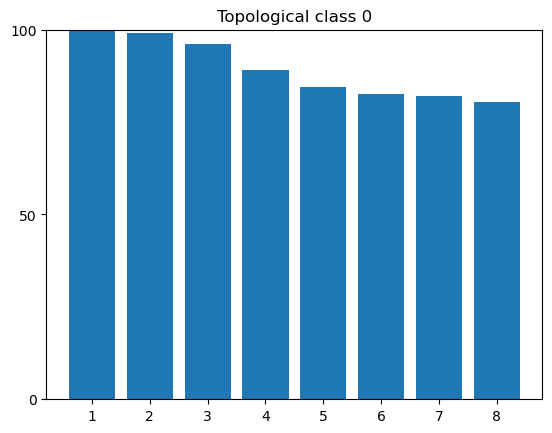

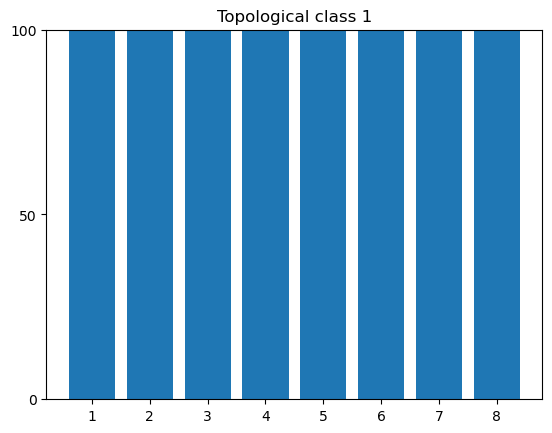

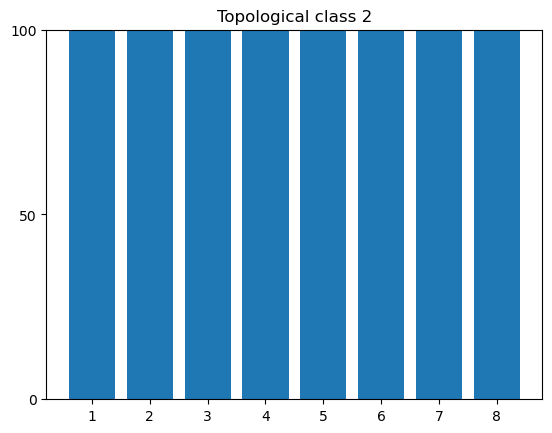

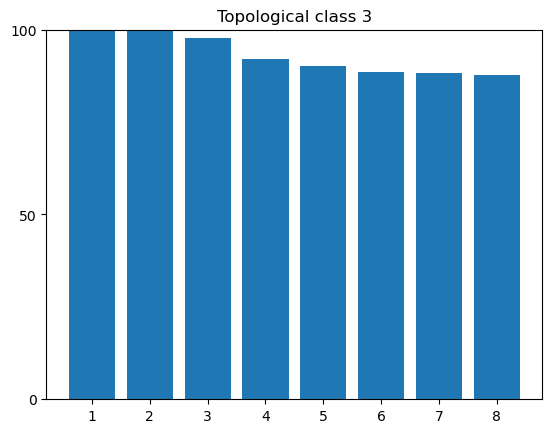

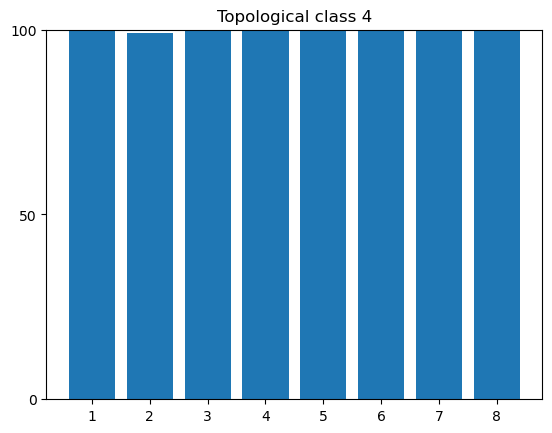

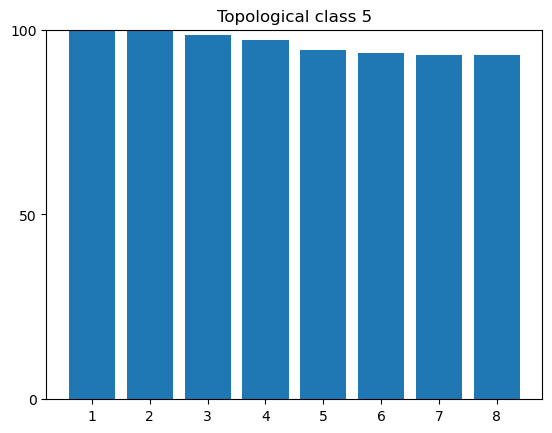

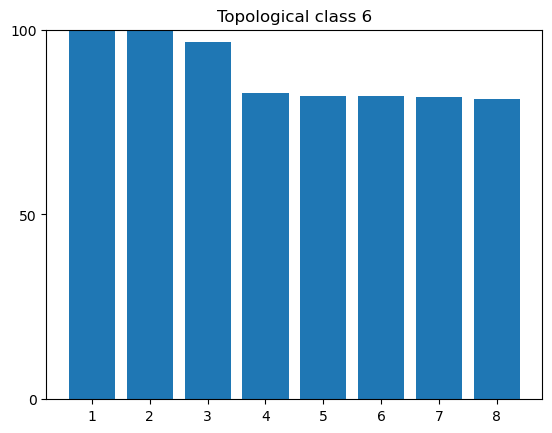

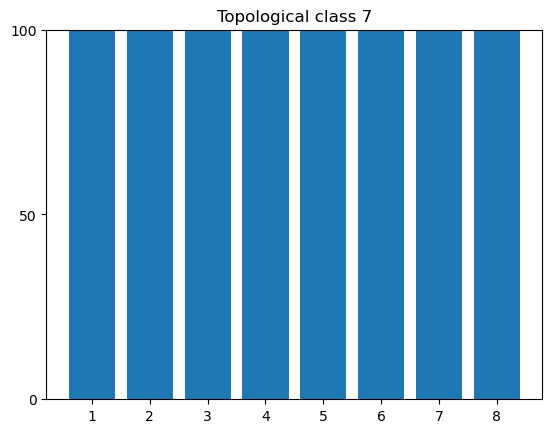

In [337]:
for i in range(1, 8)
    figure()
    bar(1:8, [smooth_accuracy_symbols[i], two_tone_accuracy_symbols[i], [contrast_accuracy_symbols[j][i] for j in 1:6]...])
    yticks([0, 50, 100])
    ylim(0, 100)
    title("Topological class $(i-1)")
    #savefig("./figures/Inverse_design_delineated_success_rates-class$(i).pdf")
end